## 0. Libraries and Personal Tools

In [1]:
import sys
import datatable as dt
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from os.path import abspath

In [2]:
# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (12, 8)
plt.style.use("fivethirtyeight")

In [3]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

# Check if the path is already added to sys.path
[p for p in sys.path if p.endswith("2022")]

# Import custom modules
from src.visualization.visualize import *
from src.utils import *

In [4]:
import gc
gc.collect()

0

## 1. Get Raw Data

In [5]:
dtypes_df = pd.read_csv("../data/raw/train_dtypes.csv")
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}

df = pd.read_feather(f"../data/interim/small_train_compressed.ftr")

In [6]:
gc.collect()

0

## 2. Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149381 entries, 0 to 2149380
Data columns (total 61 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   game_num                     int16   
 1   event_id                     int32   
 2   event_time                   float16 
 3   ball_pos_x                   float16 
 4   ball_pos_y                   float16 
 5   ball_pos_z                   float16 
 6   ball_vel_x                   float16 
 7   ball_vel_y                   float16 
 8   ball_vel_z                   float16 
 9   p0_pos_x                     float16 
 10  p0_pos_y                     float16 
 11  p0_pos_z                     float16 
 12  p0_vel_x                     float16 
 13  p0_vel_y                     float16 
 14  p0_vel_z                     float16 
 15  p0_boost                     float16 
 16  p1_pos_x                     float16 
 17  p1_pos_y                     float16 
 18  p1_pos_z              

In [8]:
df.sample(5)

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
1064040,361,361003,-9.445312,-11.851562,-13.320312,36.625000,-26.218750,-26.546875,4.898438,32.093750,...,0.000000,0.000000,-4.425781,-3.691406,0.000000,0.000000,0,A,1,0
1133116,386,386003,-96.812500,59.437500,22.828125,26.812500,48.500000,18.562500,12.398438,32.218750,...,0.000000,-8.531250,0.000000,0.000000,-8.703125,0.000000,0,A,0,0
1092092,371,371002,-54.593750,-79.875000,8.515625,4.703125,0.680176,10.945312,30.234375,35.187500,...,-7.996094,0.000000,0.000000,0.000000,0.000000,-7.929688,5,B,0,0
200771,72,72005,-50.312500,-18.046875,-82.375000,9.929688,-2.416016,14.093750,7.789062,-12.070312,...,-6.492188,-9.796875,0.000000,0.000000,0.000000,0.000000,-1,NaN,0,0
1340912,459,459004,-68.062500,-80.000000,40.750000,13.679688,0.018600,10.492188,17.437500,-26.453125,...,0.000000,-7.398438,-9.898438,0.000000,-7.601562,0.000000,-1,NaN,0,0


### 2.1. About Games, Events and Frames

In [9]:
# How many games are available in the dataset?
df.game_num.nunique()

737

In [10]:
# How many events are available in the dataset?
df.event_id.nunique()

3131

In [11]:
# How many frames per event are available in the dataset?
(
    df.groupby("event_id")
    .event_time
    .count()
    .describe()
)

count    3131.000000
mean      686.483871
std       635.133684
min        33.000000
25%       236.500000
50%       500.000000
75%       919.500000
max      6647.000000
Name: event_time, dtype: float64

### 2.2. Team and Player Scoring

In [12]:
# From the available events, what proportion of them ended up with a team scoring or without any goal?
# The remaining percentage of events are those that ended up without goal (around 17% of the events)
(
    df
    .groupby("team_scoring_next")
    .event_id
    .nunique()
    .sort_values(ascending=False)
) / df.event_id.nunique()

team_scoring_next
A    0.427020
B    0.408176
Name: event_id, dtype: float64

In [13]:
# Which player has the most goals in the dataset?
(
    df
    .groupby("player_scoring_next")
    .event_id
    .nunique()
) / df.event_id.nunique()

player_scoring_next
-1    0.164804
 0    0.143405
 1    0.142447
 2    0.141169
 3    0.132226
 4    0.145960
 5    0.129990
Name: event_id, dtype: float64

### 2.3. Event Time Duration

In [14]:
df_team_scoring = (
    df[["event_id", "team_scoring_next"]]
    .drop_duplicates()
    .set_index("event_id")
)

In [15]:
df_event_duration = (
    df_team_scoring
    .join(
        df
        .groupby(["event_id", "team_A_scoring_within_10sec"])
        [["event_time"]]
        .count()
        .pivot_table(index="event_id", columns="team_A_scoring_within_10sec", values="event_time")
        .rename(columns={0: "team_A_no_goal", 1: "team_A_goal"})
        # divide by 10 to get the number of seconds since event were recorded at 10 frames per second
        .div(10)
        )
    .join(
        df
        .groupby(["event_id", "team_B_scoring_within_10sec"])
        [["event_time"]]
        .count()
        .pivot_table(index="event_id", columns="team_B_scoring_within_10sec", values="event_time")
        .rename(columns={0: "team_B_no_goal", 1: "team_B_goal"})
        # divide by 10 to get the number of seconds since event were recorded at 10 frames per second
        .div(10)
        )
    ).reset_index()

df_event_duration["seconds_outside_scoring_range"] = df_event_duration.apply(lambda x: x["team_A_no_goal"] if x["team_scoring_next"] == "A" else x["team_B_no_goal"], axis=1)
df_event_duration["seconds_within_scoring_range"] = df_event_duration.apply(lambda x: x["team_A_goal"] if x["team_scoring_next"] == "A" else x["team_B_goal"], axis=1)

df_event_duration = (
    df_event_duration
    [["event_id", "team_scoring_next", "seconds_within_scoring_range", "seconds_outside_scoring_range"]]
    .set_index("event_id")
    )

df_event_duration["total_duration"] = df_event_duration[["seconds_within_scoring_range", "seconds_outside_scoring_range"]].sum(axis=1)

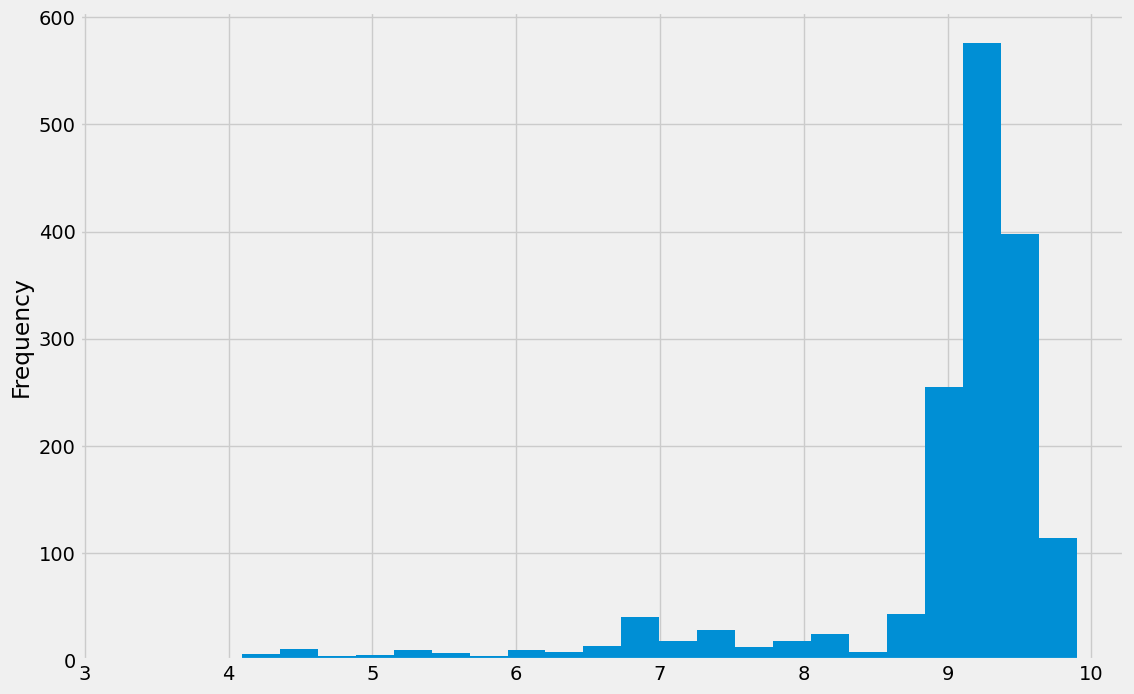

In [16]:
(
    df_event_duration
    [df_event_duration["seconds_within_scoring_range"] < df_event_duration["seconds_within_scoring_range"].quantile(0.99)]
    .seconds_within_scoring_range
    .plot.hist(bins=25)
    );

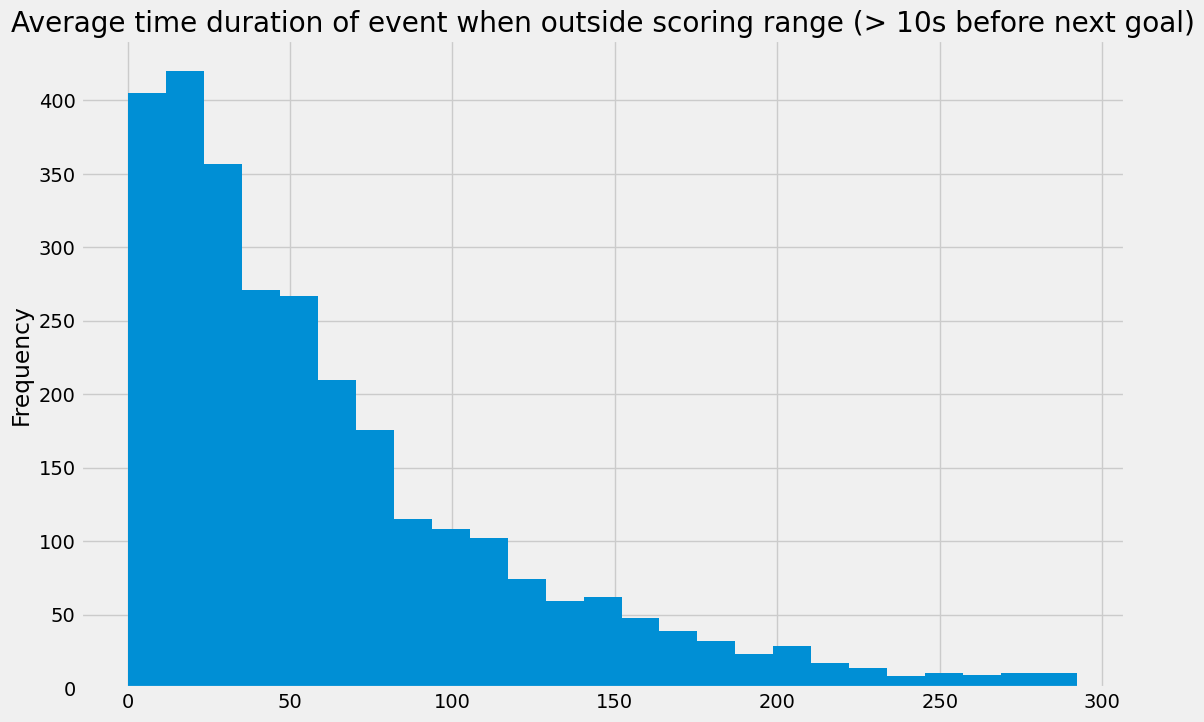

In [17]:
(
    df_event_duration
    [df_event_duration["seconds_outside_scoring_range"] < df_event_duration["seconds_outside_scoring_range"].quantile(0.99)]
    .seconds_outside_scoring_range
    .plot.hist(
        bins=25, 
        title="Average time duration of event when outside scoring range (> 10s before next goal)"
        )
    );

In [18]:
df_event_duration["total_duration"].describe()

count    3131.000000
mean       68.648387
std        63.513368
min         3.300000
25%        23.650000
50%        50.000000
75%        91.950000
max       664.700000
Name: total_duration, dtype: float64

### 2.4. Average Ball Position (Every 10 seconds)

In [19]:
df_ball = df[[
    "event_id", "event_time", 
    "ball_pos_x", "ball_pos_y", "ball_pos_z", 
    "ball_vel_x", "ball_vel_y", "ball_vel_z", 
    "team_A_scoring_within_10sec", "team_B_scoring_within_10sec"
    ]].copy()

df_ball["scoring_within_10sec"] = df_ball["team_A_scoring_within_10sec"] + df_ball["team_B_scoring_within_10sec"]
df_ball["time_inverval_before_event_ending"] = pd.cut(df_ball["event_time"], [-1000] + list(range(-300, 0, 10)) + [0])
df_ball["ball_vel_scalar"] = np.sqrt(df_ball["ball_vel_x"]**2 + df_ball["ball_vel_y"]**2 + df_ball["ball_vel_z"]**2)
df_ball["ball_distance_from_center"] = np.sqrt(df_ball["ball_pos_x"]**2 + df_ball["ball_pos_y"]**2)


In [20]:
df_ball = df_ball[[
    "event_id", "scoring_within_10sec", "event_time", "time_inverval_before_event_ending", 
    "ball_pos_x", "ball_pos_y", "ball_pos_z", "ball_vel_scalar", "ball_distance_from_center"
    ]]

In [21]:
df_avg_ball_10s = (
    df_ball
    .groupby(["scoring_within_10sec", "event_id", "time_inverval_before_event_ending"])
    [["ball_pos_x", "ball_pos_y", "ball_pos_z", "ball_vel_scalar", "ball_distance_from_center"]]
    .mean()
    .dropna(how="all")
    .reset_index()
    )

In [22]:
# df_avg_ball_10s["ball_vel_scalar"] = pd.cut(
#     x=df_avg_ball_10s["ball_vel_scalar"], 
#     bins=list(range(0, 41, 10)) + [100], 
#     right=False, 
#     )

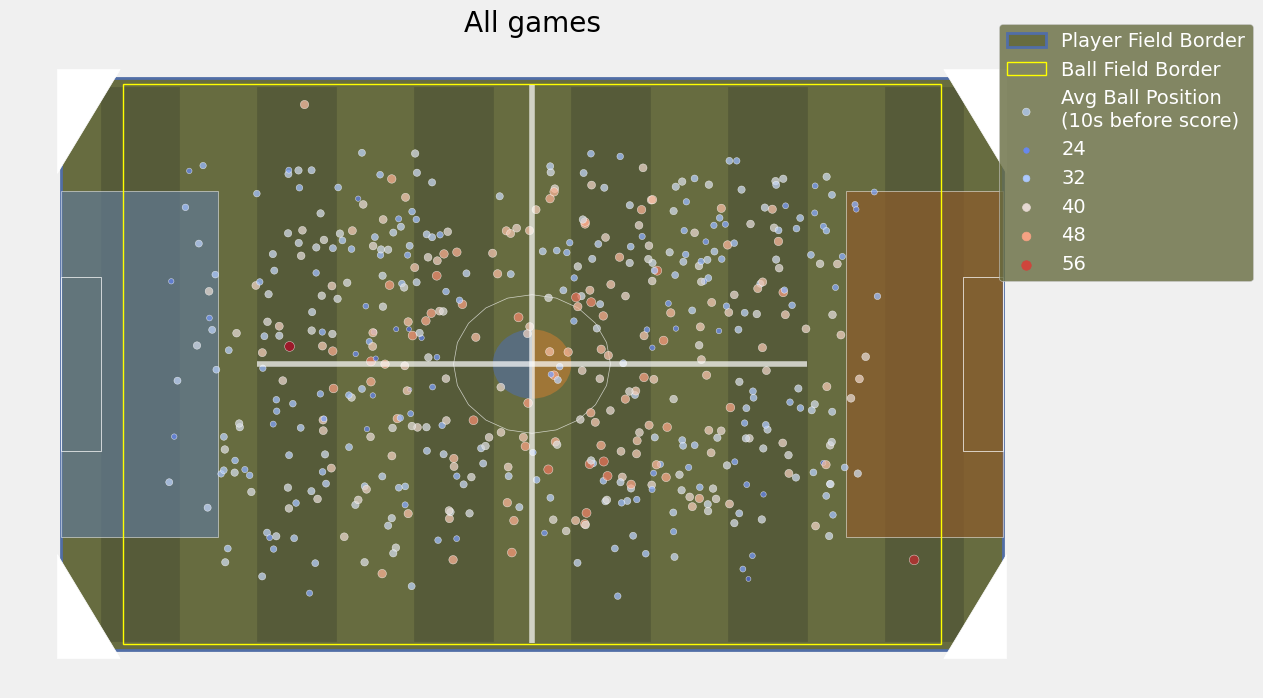

In [23]:
sample_df = df_avg_ball_10s[
    (df_avg_ball_10s["scoring_within_10sec"] == 1)
    & (1 < df_avg_ball_10s["ball_distance_from_center"])
    ].sample(frac=0.2).copy()

meta = {
    "game_num": False,
    "event_id": False,
    "event_time": False,
}

fig, ax = plt.subplots(1, figsize=(12, 8))
rl_fig, rl_ax = draw_rocket_league_ball(
    data=sample_df, 
    meta=meta,
    field=(fig, ax)
);

/home/ian/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022/src/visualization/visualize.py:177: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data.columns.str.contains("(^[p0-9_]+)([pos_]+x)")
/home/ian/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022/src/visualization/visualize.py:180: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data.columns.str.contains("(^[p0-9_]+)([pos_]+y)")


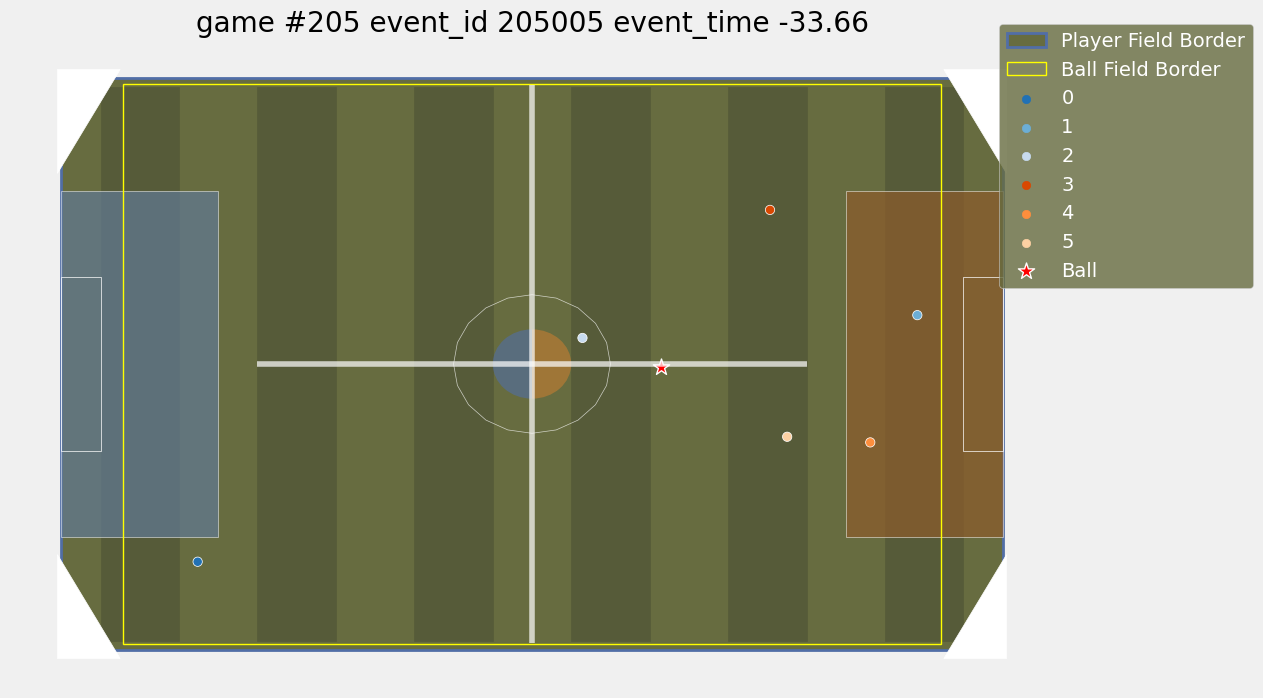

In [30]:
meta = {
    "game_num": 205,
    "event_id": 205005,
    "event_time": -33.65625,
}

fig, ax = plt.subplots(1, figsize=(12, 8))
rl_fig, rl_ax = draw_rocket_league_position(
    data=df, 
    meta=meta,
    field=(fig, ax)
);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter



def myplot(x, y, s, bins=1000):
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    return heatmap.T, extent

In [ ]:
N = 9

cats = df_avg_ball_10s[df_avg_ball_10s["scoring_within_10sec"] == 0].time_inverval_before_event_ending.cat.categories.tolist()[-N:-1]
df_avg_ball_no10s = df_avg_ball_10s[df_avg_ball_10s["scoring_within_10sec"] == 0].copy()

In [ ]:
figs, axs = plt.subplots(3, 3, figsize=(10, 10))

for ax, i in zip(axs.flatten(), range(N)):
    
    if i == N-1:
        df_aux = df_avg_ball_10s[
            (df_avg_ball_10s["scoring_within_10sec"] == 1)
            & (10 < df_avg_ball_10s["ball_distance_from_center"])
            ]

        img, extent = myplot(df_aux.ball_pos_y, df_aux.ball_pos_x, 16)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Ball distribution when\ngoal is scored within 10s")
    
    else:
        df_aux = df_avg_ball_no10s[
            (df_avg_ball_no10s["scoring_within_10sec"] == 0)
            & (10 < df_avg_ball_no10s["ball_distance_from_center"])
            & (df_avg_ball_no10s["time_inverval_before_event_ending"] == cats[i])
            ]

        # Generate some test data
        x = df_aux.ball_pos_y
        y = df_aux.ball_pos_x

        img, extent = myplot(x, y, 16)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title(f"From {N*10 - (10*i)}s to {N*10 - (10*(i+1))}s")